In [49]:
# 구글 드라이버 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%pwd

'/content/drive/My Drive'

In [51]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM

# 하이퍼 파라미터
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 100
NUM_CLASSES = 4 # 클래스 개수
CLASS_MODE = 'categorical'

BASE_PATH = '/content/drive/MyDrive'

In [52]:
%pwd
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


# 데이터 LSTM에 맞게 전처리

In [66]:
# 전체 csv는 80(frame수), 2의 size로 구성 가정
# 라벨링은 각 동작 csv의 라벨(동작 번호)를 통해

# 학습데이터 및 모델 경로 설정
csv_dir = '/content/drive/MyDrive/gesture_csv_624'

# (80, 2), 프레임*(x,y)로 원하는 학습데이터 형태로 분할
IMAGE_SIZE = (640, 640)
DATA_FRAME = 80
INPUT_SHAPE = (DATA_FRAME, 2) # xy쌍
data_X, data_y = [], []
label_list = [dir for dir in os.listdir(csv_dir) if os.path.isdir(os.path.join(csv_dir, dir))] # [다음, 이전, ...]
label_list.sort()

for label, label_name in enumerate(label_list):
  now_label_path = os.path.join(csv_dir, label_name)
  csv_list = [fname for fname in os.listdir(now_label_path) if os.path.splitext(fname)[-1]=='.csv']

  # csv파일 읽어오기
  for csv_name in csv_list:
    df = pd.read_csv(os.path.join(now_label_path, csv_name), header=None)

    # MinMaxScaler가 아닌 캔버스 크기 대비 위치 비율로 data 스케일링 진행
    for i in range(2):
      df[df.columns[i]] = df[df.columns[i]]/IMAGE_SIZE[i%2]
      
    data_X.append(df)
    data_y.append(label)

# label은 OneHotEncoding
data_y = keras.utils.to_categorical(data_y)

to_shuff_all = [[x,y] for x, y in zip(data_X, data_y)]
random.shuffle(to_shuff_all)
data_X = [tmp[0] for tmp in to_shuff_all]
data_y = [tmp[1] for tmp in to_shuff_all]

# train, val, test 분리 7, 2, 1
train_idx = int(len(data_y) * 0.7)
val_idx = int(len(data_y ) * 0.9)

X_train, y_train = np.array(data_X[:train_idx]), np.array(data_y[:train_idx])
X_val, y_val = np.array(data_X[train_idx:val_idx]), np.array(data_y[train_idx:val_idx])
X_test, y_test = np.array(data_X[val_idx:]), np.array(data_y[val_idx:])

In [67]:
X_train.shape, X_val.shape, X_test.shape

((831, 80, 2), (238, 80, 2), (119, 80, 2))

In [70]:
label_list

['01next_csv', '02previous_csv', '03S_csv', '04W_csv']

# 모델 구현

In [79]:
def create_model():
  model = tf.keras.Sequential()
  model.add(layers.Input((DATA_FRAME,2)))
  model.add(layers.LSTM(220, activation='relu', return_sequences=True))
  model.add(layers.LSTM(220, activation='relu', return_sequences=False))
  model.add(layers.Dense(10))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

  return model

In [80]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 80, 220)           196240    
_________________________________________________________________
lstm_11 (LSTM)               (None, 220)               388080    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2210      
_________________________________________________________________
batch_normalization_8 (Batch (None, 10)                40        
_________________________________________________________________
re_lu_2 (ReLU)               (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 44        
Total params: 586,614
Trainable params: 586,594
Non-trainable params: 20
_______________________________________________

In [81]:
rl_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)
# 하이퍼 파라미터
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 100

N_TRAIN, N_TEST = X_train.shape[0], X_test.shape[0]
steps_per_epoch = N_TRAIN // N_BATCHS
validation_steps = int(np.ceil(N_TEST / N_BATCHS))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(N_BATCHS)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

history = model.fit(train_dataset,
                    epochs=N_EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_dataset,
                    validation_steps=validation_steps,
                    callbacks=[rl_callback])

Epoch 1/100
8/8 [==============================] - 3s 174ms/step - loss: 1.3490 - accuracy: 0.3587 - val_loss: 1.3696 - val_accuracy: 0.2773
Epoch 2/100
8/8 [==============================] - 1s 124ms/step - loss: 1.1709 - accuracy: 0.4563 - val_loss: 1.3505 - val_accuracy: 0.4202
Epoch 3/100
8/8 [==============================] - 1s 124ms/step - loss: 1.0840 - accuracy: 0.4812 - val_loss: 1.3471 - val_accuracy: 0.4370
Epoch 4/100
8/8 [==============================] - 1s 124ms/step - loss: 1.0519 - accuracy: 0.4787 - val_loss: 1.2752 - val_accuracy: 0.4370
Epoch 5/100
8/8 [==============================] - 1s 128ms/step - loss: 1.0165 - accuracy: 0.5675 - val_loss: 1.2582 - val_accuracy: 0.3950
Epoch 6/100
8/8 [==============================] - 1s 126ms/step - loss: 0.9243 - accuracy: 0.5850 - val_loss: 1.3056 - val_accuracy: 0.3109
Epoch 7/100
8/8 [==============================] - 1s 130ms/step - loss: 0.8821 - accuracy: 0.6425 - val_loss: 1.2377 - val_accuracy: 0.4454
Epoch 8/100
8

In [82]:
model.evaluate(test_dataset)

MODEL_PATH = '/content/drive/MyDrive/LSTM_gesture_model'
# # h5형식으로 저장
# model_h5_path = os.path.join(MODEL_PATH, 'lstm_model.h5')

2/2 [==============================] - 0s 24ms/step - loss: 0.1002 - accuracy: 0.9832


[0.10019071400165558, 0.9831932783126831]

In [83]:
# 학습 결과 시각화
def plot_result(history, ymin=None, ymax=None):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)

    plt.plot(range(1,N_EPOCHS+1), history.history['loss'], label='train loss')
    plt.plot(range(1,N_EPOCHS+1), history.history['val_loss'], label='validation loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if ymin!=None and ymax!=None:
        plt.ylim(ymin, ymax)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, N_EPOCHS+1), history.history['accuracy'], label='train accuracy')
    plt.plot(range(1, N_EPOCHS+1), history.history['val_accuracy'], label='validation accuracy')
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if ymin!=None and ymax!=None:
        plt.ylim(ymin, ymax)
    plt.legend()

    plt.tight_layout()
    plt.show()

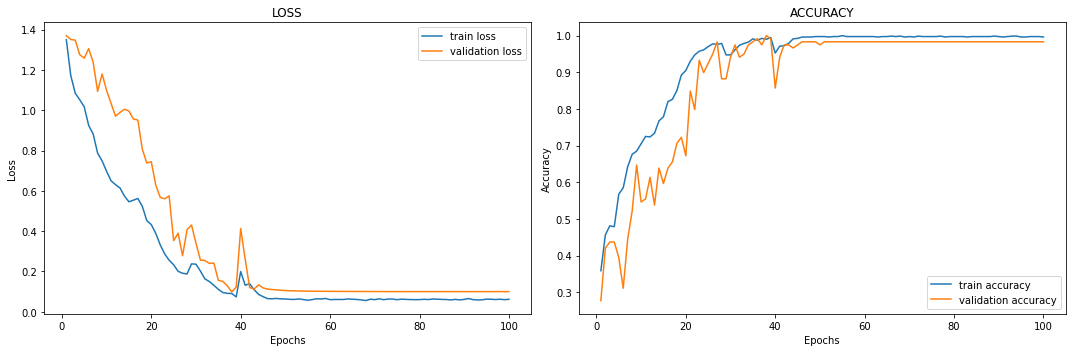

In [84]:
plot_result(history)